In [2]:
import pandas as pd
import numpy as np

Column_names = ['poisonous','cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat']
df = pd.read_csv("C:/Users/Lenovo/Desktop/30_Project/agaricus-lepiota.data", delimiter = ",", names = Column_names)
print(df.head())
df.shape[0]
df.dtypes

  poisonous cap-shape cap-surface cap-color bruises odor gill-attachment  \
0         p         x           s         n       t    p               f   
1         e         x           s         y       t    a               f   
2         e         b           s         w       t    l               f   
3         p         x           y         w       t    p               f   
4         e         x           s         g       f    n               f   

  gill-spacing gill-size gill-color  ... stalk-surface-below-ring  \
0            c         n          k  ...                        s   
1            c         b          k  ...                        s   
2            c         b          n  ...                        s   
3            c         n          n  ...                        s   
4            w         b          k  ...                        s   

  stalk-color-above-ring stalk-color-below-ring veil-type veil-color  \
0                      w                      w         

poisonous                   object
cap-shape                   object
cap-surface                 object
cap-color                   object
bruises                     object
odor                        object
gill-attachment             object
gill-spacing                object
gill-size                   object
gill-color                  object
stalk-shape                 object
stalk-root                  object
stalk-surface-above-ring    object
stalk-surface-below-ring    object
stalk-color-above-ring      object
stalk-color-below-ring      object
veil-type                   object
veil-color                  object
ring-number                 object
ring-type                   object
spore-print-color           object
population                  object
habitat                     object
dtype: object

In [3]:
df = df.replace ('?', np.nan)
#df = df.drop(columns = ['veil-type'])
count_question_marks = (df == '?').sum().sum()
print (count_question_marks)
nan_count_total = df.isna().sum().sum()
print(f"Total number of NaN values in the DataFrame: {nan_count_total}")

y_dummies = pd.get_dummies(df['poisonous'])
y_dummies = y_dummies.drop(columns=['e'])
y_dummies = y_dummies.rename(columns={'p': 'poisonous'})
print(y_dummies)
print (df.shape)

0
Total number of NaN values in the DataFrame: 2480
      poisonous
0          True
1         False
2         False
3          True
4         False
...         ...
8119      False
8120      False
8121      False
8122       True
8123      False

[8124 rows x 1 columns]
(8124, 23)


In [4]:
y= y_dummies
y = y.values.ravel()
X = df.drop('poisonous', axis = 1)
count_nan = X.isna().sum().sum()
print (count_nan)

2480


In [8]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
ordinal_feature = ['ring-number', 'population']
ordinal_categories = [['n', 'o', 't'], ['y','v','s','n','c','a']]
categorical_feature = X.columns.difference(ordinal_feature)

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant',fill_value='missing')),
    ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('ord', OrdinalEncoder(categories = ordinal_categories), ordinal_feature),
        ('cat', categorical_transformer, categorical_feature) 
    ])

In [25]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import pandas as pd

In [13]:
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import pandas as pd

def machine_learning_pipeline (model_name, models, param_grids,X,y,preprocessor):
    model_class = models[model_name] 
    test_scores = []
    predict_value = []
    true_value = []
    for i in range(4):
        X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state=i*42)

        # kfold
        kf = KFold(n_splits=4, shuffle=True, random_state=42)
        test_acc = []
        mean_val_acc = []
        for p in range(len(ParameterGrid(param_grids))):
            val_acc = []
            for fold, (train_index, val_index) in enumerate(kf.split(X_other, y_other), start=1):
                X_train = X_other.iloc[train_index]
                X_val = X_other.iloc[val_index]
                y_train = y_other[train_index]
                y_val = y_other[val_index]
                params = ParameterGrid(param_grids)[p]
                model = model_class (**params)
                pipe = make_pipeline(preprocessor, model)
                pipe.fit(X_train, y_train)
                y_val_pred = pipe.predict (X_val)
                acc_score = accuracy_score (y_val,y_val_pred)
                val_acc.append (acc_score)
            mean_val_score = np.mean(val_acc)
            mean_val_acc.append (mean_val_score)
            
        best_index = np.argmax (mean_val_acc)
        best_params =  ParameterGrid(param_grids)[best_index]
        best_model = model_class(**best_params)
        pipe = make_pipeline(preprocessor, best_model)
        pipe.fit(X_other, y_other)
        y_test_pred = pipe.predict (X_test)
        true_value.append(y_test)
        predict_value.append (y_test_pred)
        
        test_acc = accuracy_score (y_test, y_test_pred)
        test_scores.append (test_acc)
        best_model_overall = model_class(**best_params)
    return predict_value, true_value, best_model, model_name, best_params, test_scores, np.mean(test_scores), np.std(test_scores)

In [14]:
models = {
    "LogReg":LogisticRegression,
    "RF":RandomForestClassifier,
    "XGBoost":XGBClassifier,
    "SVC": SVC
}


In [24]:
param_grids = {
        "penalty": ["l1","l2",None],
        "C": [0.01,0.1,1,10,100],
        "solver": [ "saga"]
    }

In [21]:
predict_value, true_value, best_model, model_name, best_params, test_scores, mean_test_scores, std_test_scores = machine_learning_pipeline (
    "LogReg", models, param_grids, X,y,preprocessor)
print (mean_test_scores, std_test_scores, best_params)

0.9773846153846154 0.0026956023796823217 {'solver': 'saga', 'penalty': 'l1', 'C': 0.01}


In [29]:
param_grids = {
        "max_features": [0.25, 0.5, 0.75, 1.0],
        
        "max_depth": [1, 3, 5, 10, 30]
    }

In [27]:
predict_value, true_value, best_model, model_name, best_params, test_scores, mean_test_scores, std_test_scores = machine_learning_pipeline (
    "RF", models, param_grids, X,y,preprocessor)
print (mean_test_scores, std_test_scores, best_params)

1.0 0.0 {'max_features': 0.25, 'max_depth': 10}


In [32]:
param_grids = {
        'gamma': [1e-1, 1e1, 1e2],
        'C': [1e-2, 1e0, 1e2]
}

In [33]:
best_model_overall, predict_value, true_value, model_name, best_params, test_scores, mean_test_score, std_test_score = machine_learning_pipeline(
        "SVC", models, param_grids, X, y, preprocessor
    )
print( model_name, best_params, test_scores, mean_test_score, std_test_score)

SVC {'gamma': 0.1, 'C': 1.0} [1.0, 1.0, 1.0, 1.0] 1.0 0.0


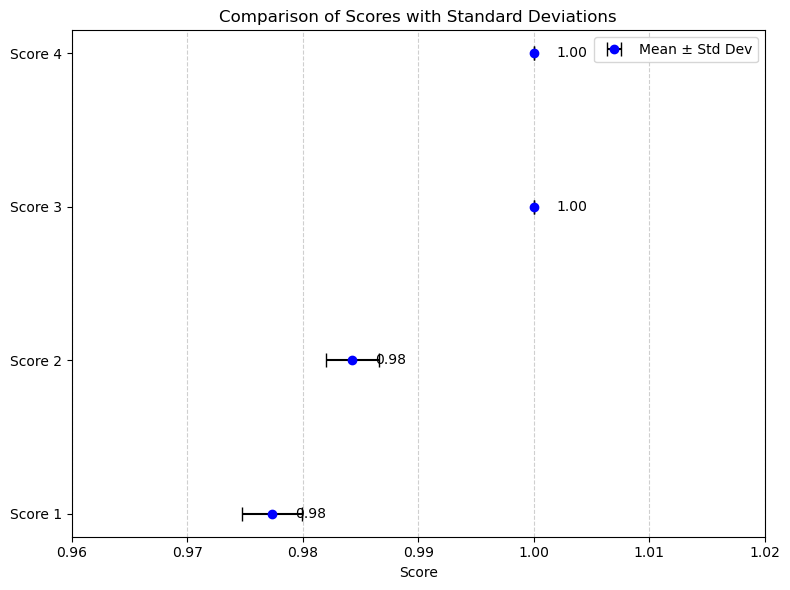

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the scores
means = [0.9773, 0.9843, 1.0, 1.0]
std_devs = [0.0026, 0.0023, 0.0, 0.0]
labels = ['SVC', 'Random Forest', 'XGBoost', 'Logistic Regression']

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot horizontal error bars
ax.errorbar(means, range(len(means)), xerr=std_devs, fmt='o', color='blue', 
            ecolor='black', capsize=5, label='Mean ± Std Dev')

# Add labels, title, and grid
ax.set_yticks(range(len(means)))
ax.set_yticklabels(labels)
ax.set_xlabel('Score')
ax.set_title('Comparison of Scores with Standard Deviations')
ax.grid(axis='x', linestyle='--', alpha=0.6)

# Set x-axis limits for better visualization
ax.set_xlim(0.96, 1.02)

# Annotate the means
for i, mean in enumerate(means):
    ax.text(mean + 0.002, i, f"{mean:.2f}", va='center', fontsize=10)

# Add legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [32]:
whole_test_sets = pd.DataFrame()
for i in range(3):
    data_set = pd.concat ([#pd.DataFrame(test_set[i]).reset_index (drop=True),
                           pd.DataFrame(true_value[i]).reset_index (drop=True),
                           pd.DataFrame(predict_value[i]).reset_index (drop=True)],axis = 1)
    whole_test_sets = pd.concat([whole_test_sets, data_set], axis = 0)
whole_test_sets.columns = ['y_true', 'y_pred']
acc_score = accuracy_score(whole_test_sets['y_true'], whole_test_sets['y_pred'])
print(whole_test_sets)
print (acc_score)

      y_true  y_pred
0       True    True
1      False   False
2      False   False
3      False   False
4      False   False
...      ...     ...
1620    True    True
1621   False   False
1622   False   False
1623   False   False
1624    True    True

[4875 rows x 2 columns]
1.0


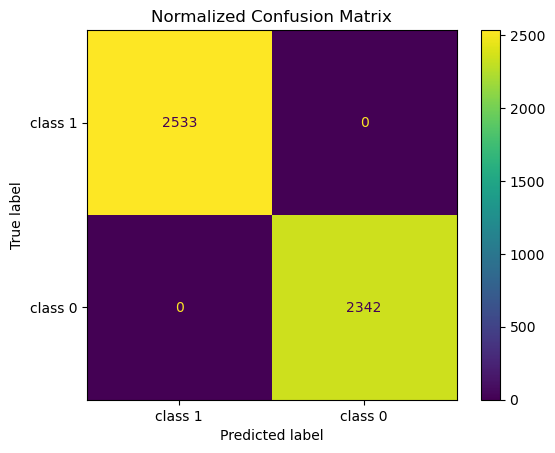

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
cm = confusion_matrix(whole_test_sets['y_true'], whole_test_sets['y_pred'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["class 1", "class 0"])
disp.plot(cmap="viridis")
plt.title(f"Normalized Confusion Matrix")
plt.show()

In [9]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

def ML_pipeline_kfold_SVC(X, y, random_state, n_folds):
    # Create a test set
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    
    # Splitter for cross-validation
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)
    
    # Pipeline with preprocessing and SVC
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('RF', RandomForestClassifier())
    ])
    # Parameter grid with step name prefixed
    param_grid = {
        "RF__max_features": [0.25,0.5],
        "RF__max_depth": [10]
    }
    
    # Prepare GridSearchCV
    grid = GridSearchCV(pipe, param_grid=param_grid, cv=kf, return_train_score=True, n_jobs=-1, verbose=True)
    
    # Perform k-fold CV on X_other
    grid.fit(X_other, y_other)
    
    # Return the grid search results and test set
    return grid, X_test, y_test

# Call the function
grid, X_test, y_test = ML_pipeline_kfold_SVC(X, y, random_state=42, n_folds=4)

Fitting 4 folds for each of 2 candidates, totalling 8 fits


[0.1710359  0.05333333 0.01013333 0.         0.         0.
 0.         0.         0.         0.        ] Index(['odor', 'gill-size', 'spore-print-color', 'habitat', 'stalk-shape',
       'cap-surface', 'cap-color', 'bruises', 'gill-attachment',
       'gill-spacing'],
      dtype='object')


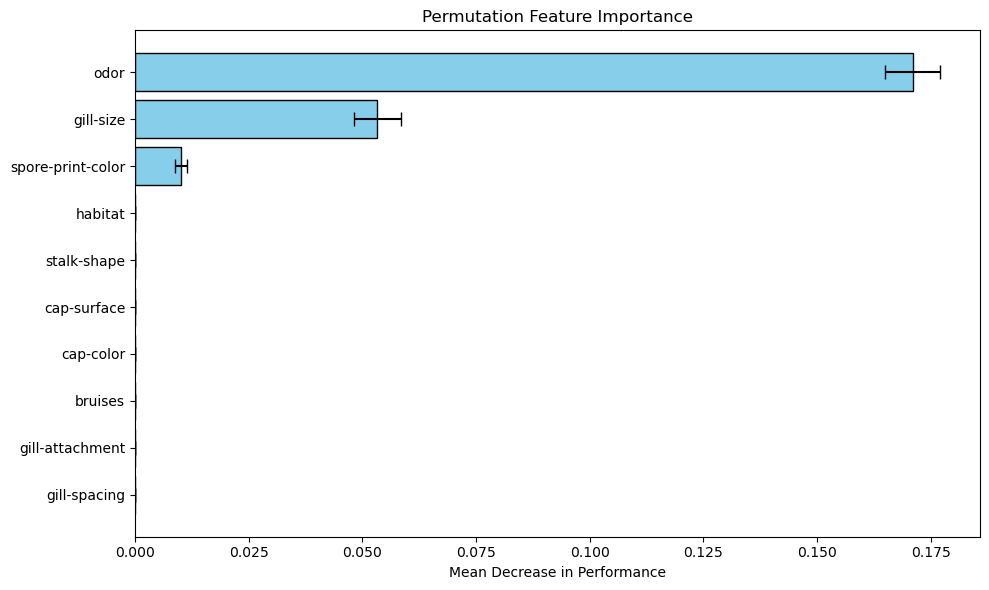

In [82]:
best_model = grid.best_estimator_  # Retrieve the best model from the grid search

# Perform permutation feature importance on the test set
perm_importance = permutation_importance(
    best_model, X_test, y_test, n_repeats=30, random_state=42, n_jobs=-1
)

# Extract the importance values
feature_importances = perm_importance.importances_mean
feature_importance_std = perm_importance.importances_std

# Sort the features by importance
sorted_idx = np.argsort(feature_importances)[::-1][:10]
sorted_importances = feature_importances[sorted_idx]
sorted_importance_std = feature_importance_std[sorted_idx]
sorted_features = X_test.columns[sorted_idx]
print (sorted_importances, sorted_features)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances, xerr=sorted_importance_std, align='center', color='skyblue', edgecolor='black', capsize=5)
plt.xlabel('Mean Decrease in Performance')
plt.title('Permutation Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.tight_layout()
plt.savefig ("permutation feature importance", dpi = 300)
plt.show()

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest model
rf =  grid.best_estimator_
rf.fit(X_train, y_train)

# Extract built-in feature importance
feature_importances = rf.feature_importances_

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Print the feature importance
print(importance_df)

In [11]:
import shap
shap.initjs()

In [12]:
X_test_transformed = grid.best_estimator_.named_steps['preprocessor'].transform(X_test)
masker = shap.maskers.Independent(X_test_transformed)
final_model = grid.best_estimator_.named_steps['RF']
prediction_function = lambda X: final_model.predict_proba(X)
background = shap.sample(X_test_transformed, 100)  # Reduce to 100 samples
explainer = shap.KernelExplainer(prediction_function, background)
shap_values = explainer.shap_values(X_test_transformed[:1000])
print(np.shape(shap_values))
print("Shape of SHAP values for each class:", [np.shape(vals) for vals in shap_values])
class_idx = 1
index = 1



  0%|          | 0/1000 [00:00<?, ?it/s]

(1000, 110, 2)
Shape of SHAP values for each class: [(110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2), (110, 2

In [114]:
print(np.shape(shap_values))

(1000, 110, 2)


SHAP Values Shape: (1000, 110)
Features Shape: (1000, 110)


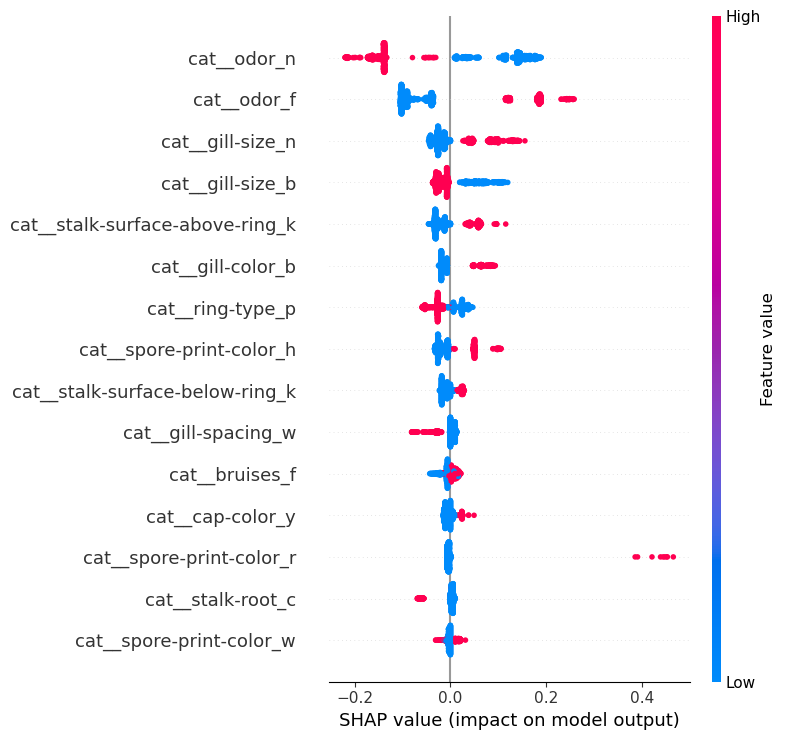

In [117]:
class_index = 1
index = 1
expected_value = explainer.expected_value[class_idx]
shap_values_instance = shap_values[index][:,class_index] 
X_test_transformed = grid.best_estimator_.named_steps['preprocessor'].transform(X_test)
X_test_transformed = X_test_transformed[:1000]
shap_values_selected = shap_values[:,:, class_idx] 
print(f"SHAP Values Shape: {shap_values_selected.shape}")
print(f"Features Shape: {X_test_transformed.shape}")

plt.figure()
plot = shap.summary_plot(
    shap_values_selected,               # SHAP values for the selected class
    X_test_transformed,     # Corresponding input features
    feature_names=grid.best_estimator_.named_steps['preprocessor'].get_feature_names_out(),
    max_display=15                        # Number of top features to display
)

In [112]:
import shap
class_idx = 1  # Class of interest (e.g., "poisonous" or class 1)
index = 5     # Index of the instance to analyze


# Ensure SHAP values are correctly indexed
shap_values_instance = shap_values[index, :, class_idx] 
X_test_transformed = grid.best_estimator_.named_steps['preprocessor'].transform(X_test)# Shape: (110,)
features_instance = X_test_transformed[index]         # Shape: (110,)


shap.force_plot(
    base_value=explainer.expected_value[class_idx],  # Expected value for the specified class
    shap_values=shap_values_instance,               # SHAP values for the instance
    features=features_instance,                     # Feature values for the instance
    feature_names=grid.best_estimator_.named_steps['preprocessor'].get_feature_names_out()
)

In [106]:
print (shap_values.shape)
features=X_test_transformed[index, :]
print (features.shape)

(1000, 110, 2)
(110,)


Top 10 Feature Importance (MDI):
                             Feature  Importance
54                       cat__odor_n    0.198000
51                       cat__odor_f    0.108523
39                  cat__gill-size_n    0.105392
98   cat__stalk-surface-above-ring_k    0.091412
38                  cat__gill-size_b    0.058267
64          cat__spore-print-color_h    0.043992
26                 cat__gill-color_b    0.042140
102  cat__stalk-surface-below-ring_k    0.033225
62                  cat__ring-type_p    0.031607
1                    ord__population    0.021586


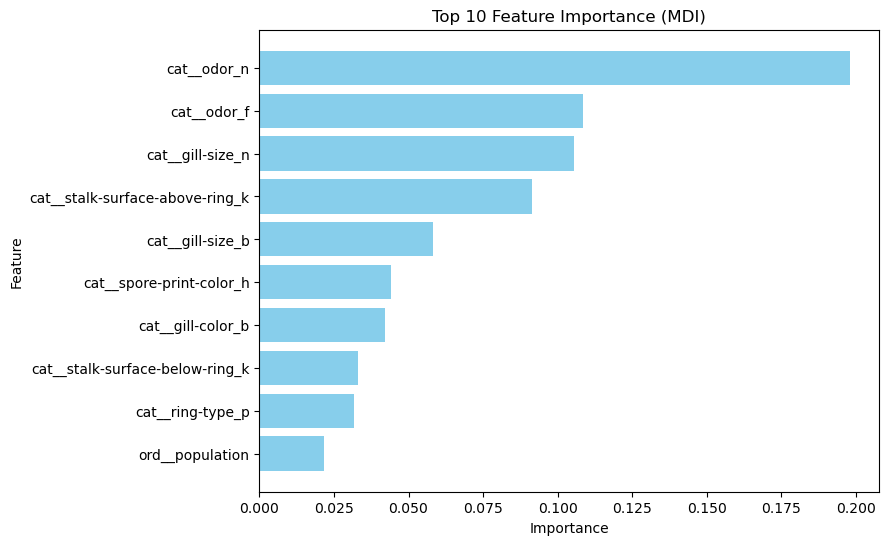

In [119]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
import pandas as pd
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt


# Train a Random Forest model
rf = grid.best_estimator_
model = rf.named_steps['RF']

# Extract feature importance (MDI method)
mdi_importance = model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': rf.named_steps ['preprocessor'].get_feature_names_out(),
    'Importance': mdi_importance
}).sort_values(by='Importance', ascending=False)

top_10_features = feature_importance_df.head(10)

# Display the top 10 feature importance
print("Top 10 Feature Importance (MDI):")
print(top_10_features)

# Visualization for top 10 features
plt.figure(figsize=(8, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importance (MDI)')
plt.gca().invert_yaxis()  # Reverse the order to show the highest importance at the top
plt.savefig ('mdi.png', dpi = 300)
plt.show()

# # Display the feature importance
# print("Feature Importance (MDI):")
# print(feature_importance_df)

# # Visualization
# import matplotlib.pyplot as plt

# # Plot the MDI feature importance
# plt.figure(figsize=(8, 6))
# plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
# plt.xlabel('Importance')
# plt.ylabel('Feature')
# plt.title('Feature Importance (MDI)')
# plt.gca().invert_yaxis()  # Reverse the order to show the highest importance at the top
# plt.show()
